# ENTREGA COLOREADO

### Contexto general

Los autoencoders son un tipo de red neuronal que está entrenada para reconstruir su entrada. Consiste en un "encoder" y un "decider", donde el "encoder" asigna la entrada a una representación de menor dimensión (también conocida como representación o **vector latente**), y el "decoder" asigna la representación latente al espacio de entrada original.

Una de las tareas propuestas es el coloreado de una imágenes en blanco y negro (escala de grises). Para colorear imágenes en escala de grises con un autoencoder, se puede usar una variante de este conocido como autoencoder convolucional, que es muy adecuada para procesar imágenes. La entrada de este modelo sería la imagen en escala de grises y la salida sería la versión coloreada de la imagen. El "encoder" aprendería a extraer características de la imagen en escala de grises y el "decoder" aprendería a asignar estas características a los colores correspondientes.

Vale la pena señalar que colorear imágenes en escala de grises con un autoencoder puede ser una tarea desafiante, especialmente si las imágenes en escala de grises no están bien alineadas con las versiones en color (por ejemplo, si las imágenes en escala de grises se obtuvieron reduciendo las versiones en color). En tales casos, estos modelos pueden tener dificultades para reconstruir con precisión las versiones en color de las imágenes en escala de grises.

### Dataset

El dataset escogido ha sido el conjunto de imágenes de los Simpsons cuyas dimensiones originales vienen dadas en 32 x 32 y con una codificación a color RGB.

### Librerías 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.io import read_file, decode_jpeg, decode_png, ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
import cv2
import matplotlib.pyplot as plt

### Dataloader

Para poder trabajar de forma cómoda con nuestro dataser, crearemos un DataLoader, un objeto utilizado en la biblioteca PyTorch (y otras similares) para cargar y procesar grandes conjuntos de datos de manera eficiente durante el entrenamiento de un modelo de aprendizaje automático.

- **En lugar de cargar todos los datos en la memoria de una sola vez, el data loader divide los datos en trozos más pequeños llamados batches y los procesa de manera secuencial durante el entrenamiento.**

Además, en nuestro caso será utilizado para modificar el estado "natural" de las imágenes, realizando los siguientes cambios:
1. Cargaremos la imágenes en formato RGB, ya que se está utilizando la función cv2.imread() de la biblioteca OpenCV para leer una imagen desde el disco y cargarla en memoria. Esta función, por defecto, carga las imágenes en formato BGR.
2. Aumentaremos su tamaño a una dimensión de 64 x 64.
3. Cambiamos el formato de las imágenes al esquema de color YCrCb, el cual es el "target" del trabajo.
4. Separamos en luminancia (Y), rojo ajustado (Cr) y azul ajustado (Cb).
5. Finalmente, normalizamos los 3 canales, dividiendolos entre 255, para ajustar los valores entre 0 y 1.

In [2]:
# DATASET
import os

# read dataset for u-net
class Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = [os.path.splitext(f)[0] for f in os.listdir(data_dir)]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        # read image
        img = cv2.imread(os.path.join(self.data_dir, file_name + ".png"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64,64))

        imgYCC = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
                        
        #separate
        Y=imgYCC[:,:,0]
        Cr=imgYCC[:,:,1]
        Cb=imgYCC[:,:,2]
                
        Y,Cr,Cb = Y/255.0, Cr/255.0, Cb/255.0

        return Y,Cr,Cb
        

        
ds = Dataset(".\\Simpsons")
ds_loader = DataLoader(ds, batch_size=64)

### Modelo

El modelo que hemos definido se caracteriza por los siguientes elementos:

**ENCODER**

De forma implícita se ha desarrollado un encoder en el modelo que ocupa 3 capas convolutivas. Este recibe el canal Y (luminancia) con una dimensión de 1 x 64 x 64. Este enconder devuelve un resultado con una dimensión de 32 x 16 x 16 y 64 de batch.

**DECODER**

De forma implícita se ha desarrollado un decoder en el modelo que ocupa 4 capas deconvolutivas. Dos primeras que afectan al conjunto entero de Y, y dos últimas, que nos darán por separado los otros dos canales, Cr y Cb.
Este devolverá los dos ultimos canales con un tamaño de 1 x 64 x 64.

In [3]:
class Autoencoder_COLOR(nn.Module):
    def __init__(self):
        super().__init__()        
        # 1, 64, 64 = INPUT CANAL Y
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(32, 64, 7)

        
        self.convT1 = nn.ConvTranspose2d(64, 32, 7)
        self.convT2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1) 
        self.convT2Cr = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1) 
        self.convT2Cb = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1) 
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))
        cr = torch.sigmoid(self.convT2Cr(x))
        cb = torch.sigmoid(self.convT2Cb(x))

        return cr,cb

### Cargamos el modelo y sus parámetros

Cargamos el modelo y establecemos el criterio de pérdida (error cuadrático medio), la tasa de aprendizaje y la regularización.

In [4]:
model = Autoencoder_COLOR()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, weight_decay=1e-5)

### Entrenamos el modelo

Para entrenar el modelo se ha optado por un total de 500 épocas. Por ello, recorreremos el dataset según los tres canales. Posteriormente, se calcularán los canales Cr y Cb a partir de Y, pasando este como parámetro a nuestro modelo.

* **APUNTE 1:** *Cuando utilizamos imágenes en modelos de aprendizaje, debemos tener en cuenta las dimensiones de estas. Por ello, al pasar el canal Y por el modelo (y veremos que este fenómeno ocurre con bastante frecuencia), "obligamos" a este a tener una dimensión de 1 x 64 x 64, con un batch cualquiera (el que hayamos definido en nuestro DataLoader). **Debemos en todo momento mantener las mismas dimensiones en todas las imágenes y canales para poder unirlos finalmente***

Una vez obtenidos ambos canales, calculamos la pérdida de los mismos comparándolos con los canales originales.

In [7]:
# Point to training loop video
num_epochs = 500
model = model.double()

for epoch in range(num_epochs):
    for Y, Cr, Cb in ds_loader:

        Cr_recon, Cb_recon = model(Y.view(-1, 1, 64, 64).double())

        loss = criterion(Cr.view(-1,1,64,64) , Cr_recon) + criterion(Cb.view(-1,1,64,64), Cb_recon)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:1, Loss:0.0050
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:2, Loss:0.0049
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:3, Loss:0.0050
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:4, Loss:0.0049
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:5, Loss:0.0049
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:6, Loss:0.0051
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:7, Loss:0.0050
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:8, Loss:0.0051
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:9, Loss:0.0052
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:10, Loss:0.0052
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:11, Loss:0.0050
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:12, Loss:0.0050
torch.Size([64, 1, 64, 64])
torch.Size([36, 1, 64, 64])
Epoch:13, Loss:0.

### Mostramos los resultados

Para comprobar que nuestro estudio ha sido correcto, imprimiremos las imágenes originales y las resultantes del modelo. En este caso, probaremos con 5 de nuestro dataset. Pero antes de comentar los resultados, debemos entender como reconstruir las imágenes sobre los 3 canales.

**RECONSTRUCCIÓN**

1. Una vez obtenidos los canales Cr y Cb del modelo, pasaremos **todo** a una dimensión de 64 x 64 y a formato numpy (por facilidad de representación con las librerías). 
2. Ya pasado todo al mismo formato, uniremos los tres canales (Y,Cr,Cb) en un solo array.
3. Para mostrar estos arrays como imágenes usando `imshow`, las dimensiones deben reorganizarse para que la dimensión del canal sea la última y las dimensiones correspondientes a la altura y el ancho de la imagen sean las dos primeras dimensiones.

**APUNTE 2**:*La función `np.swapaxes` se usa para intercambiar las posiciones de la primera y la segunda dimensión, y luego las posiciones de la segunda y la tercera dimensión, de modo que la matriz resultante tenga las dimensiones (ancho, alto, canal). Esto permite que la función `imshow` interprete y muestre correctamente la imagen.*

4. Finalmente, pasamos los arrays a *float32* y luego se pasan a través de la función de conversión de color cv2.COLOR_YCrCb2RGB, que convierte las imágenes del espacio de color YCrCb al color RGB. espacio. Esto es necesario porque la función `imshow` espera que las imágenes estén en el espacio de color RGB.
5. Este proceso se repite tanto para los resultados como para las imágenes originales.

Una vez acabada la reconstrucción, compararemos de forma gráfica los resultados.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


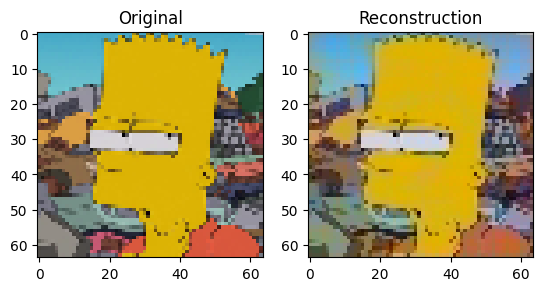

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


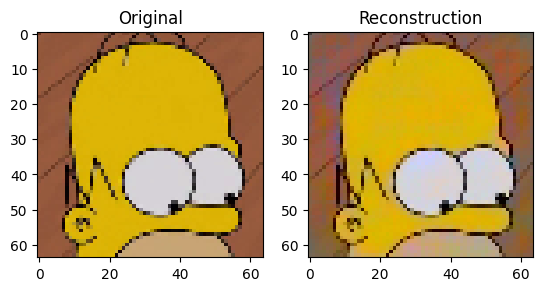

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


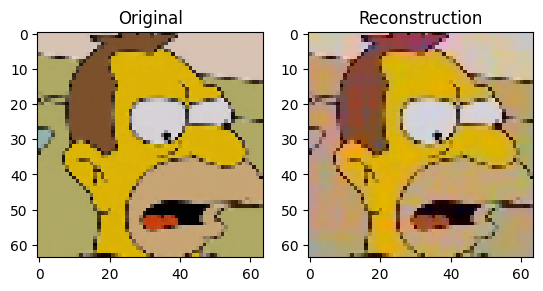

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


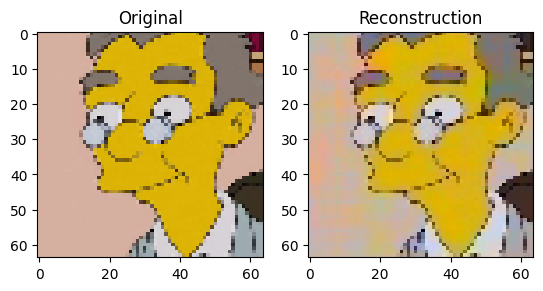

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


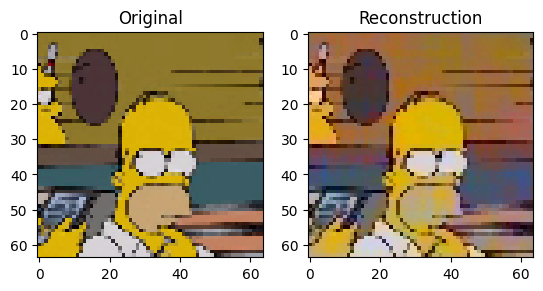

In [6]:
dataiter = iter(ds_loader)
Y, Cr, Cb = dataiter.next()

idx = 3

with torch.no_grad():
    for i in range(5):
        Cr_recon, Cb_recon = model(Y[i].view(-1, 1, 64, 64))


        # Reconstruction
        
        Cr_recon = Cr_recon.view(64, 64).numpy()
        Cb_recon = Cb_recon.view(64, 64).numpy()

        result = np.array([Y[i].numpy(), Cr_recon, Cb_recon])    
        result = np.swapaxes(result, 0, 1)
        result = np.swapaxes(result, 1, 2)

        result = cv2.cvtColor(result.astype(np.float32), cv2.COLOR_YCrCb2RGB)
        
        
        # Original

        original = np.array([Y[i].numpy(), cv2.resize(Cr[i].numpy(), (64, 64)), cv2.resize(Cb[i].numpy(), (64, 64))])
        original = np.swapaxes(original, 0, 1)
        original = np.swapaxes(original, 1, 2)

        original = cv2.cvtColor(original.astype(np.float32), cv2.COLOR_YCrCb2RGB)
        
        # Plot images
        plt.figure()
        plt.subplot(1, 2, 2)
        plt.title("Reconstruction")
        plt.imshow(result)
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(original)
        plt.show()


Como es comprobable, los resultados finales son muy similares a los originales, obteniendo un buen modelo con el que poder "colorear" imágenes que vengan en escala de grises o blanco y negro.